In [131]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Hide warning messages in notebook
# this is nice.
import warnings
warnings.filterwarnings('ignore')



In [132]:
# reading in the csvs to create dataframes
mouse_df = pd.read_csv(os.path.join("..","data","mouse_drug_data.csv"))
clinical_df = pd.read_csv(os.path.join("..","data","clinicaltrial_data.csv"))

# Combine the data into a single dataset
combined_df = pd.merge(mouse_df, clinical_df, on="Mouse ID", how="outer")

# Display the data table for preview
combined_df.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2


In [133]:
combined_df.shape

(1906, 5)

In [134]:
# no null values to worry about
combined_df.isnull().any()

Mouse ID              False
Drug                  False
Timepoint             False
Tumor Volume (mm3)    False
Metastatic Sites      False
dtype: bool

## Tumor Response to Treatment

In [135]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
mean_tumor_volume = pd.DataFrame(combined_df.groupby(["Drug", "Timepoint"]).mean()["Tumor Volume (mm3)"])
# mean_tumor_volume = combined_df.groupby(["Drug", "Timepoint"]).mean()
# Convert to DataFrame
mean_tumor_volume = mean_tumor_volume.reset_index()
# Preview DataFrame
mean_tumor_volume.head()
# fig, ax = plt.subplots()
# for name, group in mean_tumor_volume:

# plt.scatter(mean_tumor_volume["Timepoint"], mean_tumor_volume["Tumor Volume (mm3)"])

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325


In [136]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint and Convert to DataFrame
sem_tumor_volume = combined_df.groupby(["Drug", "Timepoint"]).sem()["Tumor Volume (mm3)"].reset_index()
# Preview DataFrame
sem_tumor_volume.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [ ]:
# Minor Data Munging to Re-Format the Data Frames

# Preview that Reformatting worked


In [100]:
mean_tumor_volume_rf = pd.pivot_table(mean_tumor_volume, values="Tumor Volume (mm3)",index="Timepoint",
                                      columns="Drug")
sem_tumor_volume_rf = pd.pivot_table(sem_tumor_volume, values="Tumor Volume (mm3)",index="Timepoint",
                                      columns="Drug")
sem_tumor_volume_rf

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.448593,0.164505,0.235102,0.264819,0.202385,0.218091,0.231708,0.482955,0.239862,0.188950
10,0.702684,0.236144,0.282346,0.357421,0.319415,0.402064,0.376195,0.720225,0.433678,0.263949
15,0.838617,0.332053,0.357705,0.580268,0.444378,0.614461,0.466109,0.770432,0.493261,0.370544
20,0.909731,0.359482,0.476210,0.726484,0.595260,0.839609,0.555181,0.786199,0.621889,0.533182
25,0.881642,0.439356,0.550315,0.755413,0.813706,1.034872,0.577401,0.746991,0.741922,0.602513
30,0.934460,0.490620,0.631061,0.934121,0.975496,1.218231,0.746045,0.864906,0.899548,0.800043
35,1.052241,0.692248,0.984155,1.127867,1.013769,1.287481,1.084929,0.967433,1.003186,0.881426
40,1.223608,0.708505,1.055220,1.158449,1.118567,1.370634,1.564779,1.128445,1.410435,0.998515


In [154]:
colors = {"Capomulin":"cyan","Ceftamin":"orange","Infubinol":"indigo","Ketapril":"xkcd:dried blood",
          "Naftisol":"xkcd:neon green","Placebo":"grey","Propriva":"violet","Ramicane":"red",
          "Stelasyn":"xkcd:dark green","Zoniferol":"xkcd:blue green"}


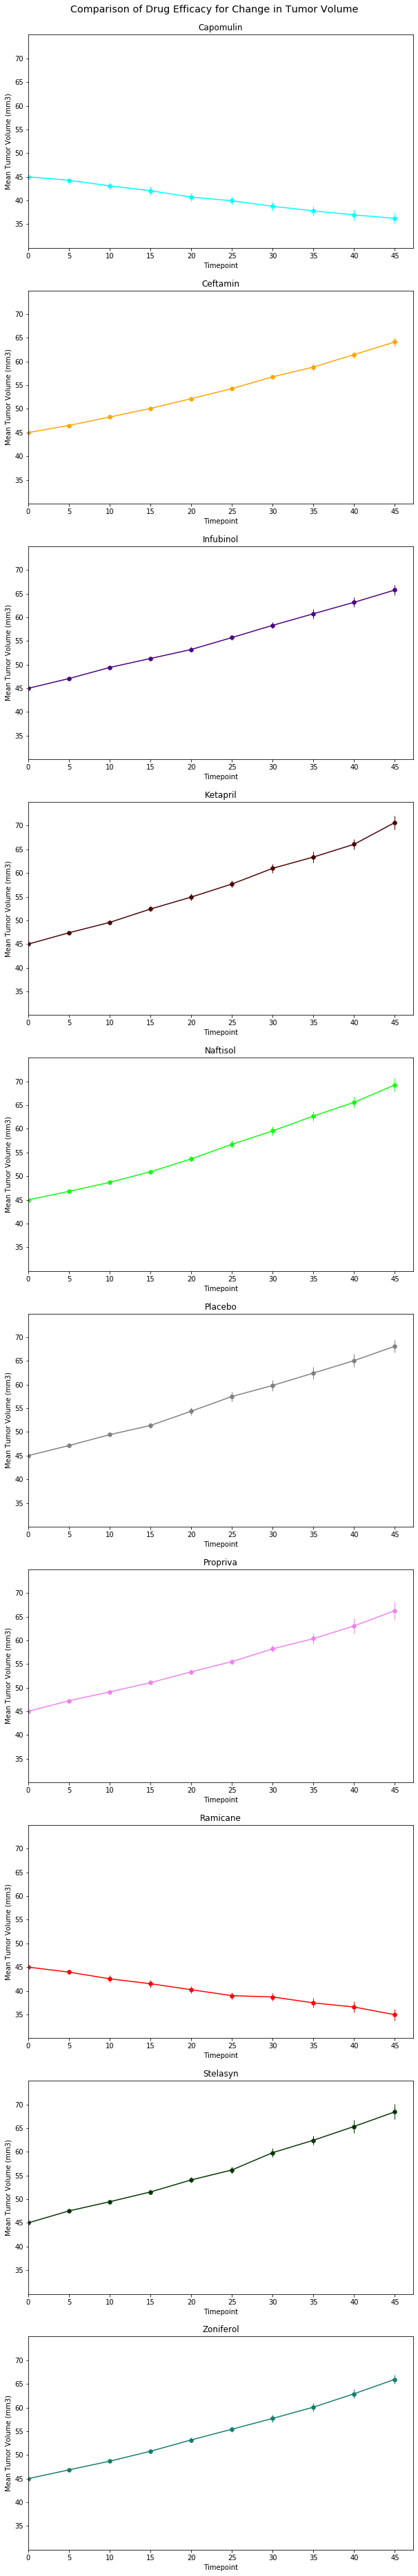

In [172]:
# Generate the Plot (with Error Bars)
# using subplots because having every drug errorbar on one graph is too crowded
# sharing x & y axes makes visual comparison easier
# plt.title
fig, (p1,p2,p3,p4,p5,p6,p7,p8,p9,p10) = plt.subplots(10, sharey=True,figsize=(10,60))
x_ticks = mean_tumor_volume_rf.index
# p1.set_xlim(min(x_ticks)*0.95, max(x_ticks)*1.05)
# p1.set_xticks(x_ticks)
p1.set_ylim(30,75)
p1.set_yticks(np.arange(35,71,5))

counter = 0
for p in (p1,p2,p3,p4,p5,p6,p7,p8,p9,p10):
    # get the drug name from the list of columns to easily get series
    drug = mean_tumor_volume_rf.columns[counter]
    p.scatter(x_ticks, mean_tumor_volume_rf[drug], c=colors[drug], s=30, label=drug)
    p.errorbar(x_ticks, mean_tumor_volume_rf[drug], sem_tumor_volume_rf[drug], c=colors[drug], 
               label=drug, elinewidth = 1)
    p.title.set_text(drug)
    p.set_xticks(x_ticks)
    p.set_xlim(min(x_ticks)*0.95, max(x_ticks)*1.05)
    p.set_xlabel("Timepoint")
    p.set_ylabel("Mean Tumor Volume (mm3)")
    counter += 1

# plt.figure(figsize = (12,14))
# for drug in mean_tumor_volume_rf:
#     plt.scatter(mean_tumor_volume_rf.index, mean_tumor_volume_rf[drug], c = colors[drug], s=16, \
#                 label=drug)
#     plt.errorbar(mean_tumor_volume_rf.index, mean_tumor_volume_rf[drug], sem_tumor_volume_rf[drug], 
#                  color= colors[drug], fmt='')
# Save the Figure
# plt.legend(loc="best")
# plt.ylabel("Mean Tumor Volume (mm3)")
# plt.xlabel("Timepoint")
# plt.tight_layout()
fig.suptitle("Comparison of Drug Efficacy for Change in Tumor Volume", fontsize="x-large")
fig.subplots_adjust(top=.97)
# plt.ylabel("")


In [ ]:
# Show the Figure
plt.show()

![Tumor Response to Treatment](../Images/treatment.png)

## Metastatic Response to Treatment

In [ ]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 

# Convert to DataFrame

# Preview DataFrame


Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.160000
          10                 0.320000
          15                 0.375000
          20                 0.652174

In [ ]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 

# Convert to DataFrame

# Preview DataFrame


Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.074833
          10                 0.125433
          15                 0.132048
          20                 0.161621

In [ ]:
# Minor Data Munging to Re-Format the Data Frames

# Preview that Reformatting worked


Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.248967,43.944859,47.527452,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,49.101541,42.531957,49.463844,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,51.067318,41.495061,51.529409,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.346737,40.238325,54.067395,53.170334


In [ ]:
# Generate the Plot (with Error Bars)

# Save the Figure

# Show the Figure


![Metastatic Spread During Treatment](../Images/spread.png)

## Survival Rates

In [ ]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)

# Convert to DataFrame

# Preview DataFrame


,Drug,Timepoint,Mouse Count
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


In [ ]:
# Minor Data Munging to Re-Format the Data Frames

# Preview the Data Frame


Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,26,25,26,25
5,25,21,25,23,23,24,25,25,25,24
10,25,20,21,22,21,24,23,24,23,22
15,24,19,21,19,21,20,17,24,23,21
20,23,18,20,19,20,19,17,23,21,17


In [ ]:
# Generate the Plot (Accounting for percentages)

# Save the Figure

# Show the Figure
plt.show()

![Metastatic Spread During Treatment](../Images/survival.png)

## Summary Bar Graph

In [ ]:
# Calculate the percent changes for each drug

# Display the data to confirm


Drug
Capomulin   -19.475303
Ceftamin     42.516492
Infubinol    46.123472
Ketapril     57.028795
Naftisol     53.923347
Placebo      51.297960
Propriva     47.241175
Ramicane    -22.320900
Stelasyn     52.085134
Zoniferol    46.579751
dtype: float64

In [ ]:
# Store all Relevant Percent Changes into a Tuple


# Splice the data between passing and failing drugs


# Orient widths. Add labels, tick marks, etc. 


# Use functions to label the percentages of changes


# Call functions to implement the function calls


# Save the Figure


# Show the Figure
fig.show()

![Metastatic Spread During Treatment](../Images/change.png)